In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy.linalg import pinv
import xgboost as xgb
from sklearn.linear_model import SGDRegressor, LinearRegression


In [2]:
data = pd.read_csv('data_new.csv')
data.head(3)

,DES,HBA,HBD,MR,T/K,Dexp,MCI,Tbm,Tcm,Vcm,Pcm,ωm,MW
0,DES2,ChCl,EG,1.2,308.57,1.1163,1.7208,439,610.73,290.69,59.92,0.94,87.6648
1,DES2,ChCl,EG,1.2,312.56,1.1142,1.7208,439,610.73,290.69,59.92,0.94,87.6648
2,DES2,ChCl,EG,1.2,313.52,1.1137,1.7208,439,610.73,290.69,59.92,0.94,87.6648


## Exploratory Data Analysis

In [10]:
data.describe()

,MR,T/K,Dexp,MCI,Tbm,Tcm,Vcm,Pcm,ωm,MW
count,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,1.329150,330.743607,1.143591,4.841156,547.417004,758.807470,502.415587,46.672409,1.085648,148.856746
std,0.128655,14.322110,0.074208,1.886399,57.213633,86.800228,124.667055,12.138158,0.144536,40.406231
min,1.100000,307.680000,1.016000,1.607000,434.000000,610.730000,290.690000,24.640000,0.900000,74.480000
25%,1.200000,317.782500,1.089725,3.526000,502.000000,680.770000,438.330000,32.570000,0.970000,115.870000
50%,1.300000,330.145000,1.119850,4.579400,548.000000,780.700000,496.390000,51.080000,1.040000,147.540000
75%,1.400000,342.977500,1.189800,5.940100,593.000000,865.480000,632.520000,56.950000,1.210000,179.600000
max,1.500000,354.190000,1.291900,9.285700,639.000000,882.210000,702.540000,63.720000,1.360000,236.270000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DES     494 non-null    object 
 1   HBA     494 non-null    object 
 2   HBD     494 non-null    object 
 3   MR      494 non-null    float64
 4   T/K     494 non-null    float64
 5   Dexp    494 non-null    float64
 6   MCI     494 non-null    float64
 7   Tbm     494 non-null    int64  
 8   Tcm     494 non-null    float64
 9   Vcm     494 non-null    float64
 10  Pcm     494 non-null    float64
 11  ωm      494 non-null    float64
 12  MW      494 non-null    float64
dtypes: float64(9), int64(1), object(3)
memory usage: 50.3+ KB


In [6]:
data.isna().sum()

DES     0
HBA     0
HBD     0
MR      0
T/K     0
Dexp    0
MCI     0
Tbm     0
Tcm     0
Vcm     0
Pcm     0
ωm      0
MW      0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
data.nunique()

DES      40
HBA       3
HBD       3
MR        5
T/K     431
Dexp    436
MCI      40
Tbm      38
Tcm       9
Vcm       9
Pcm      38
ωm       26
MW       40
dtype: int64

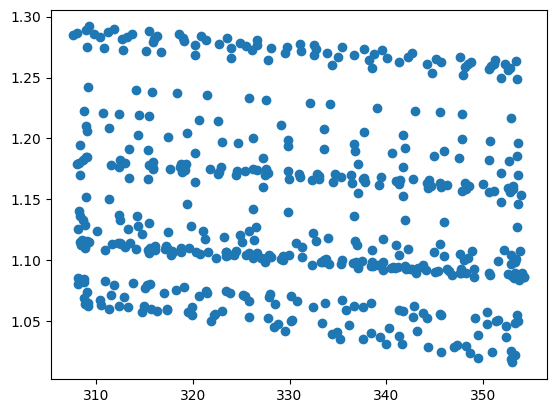

In [21]:
from matplotlib import pyplot as plt
temp = data.iloc[:,4]
density = data.iloc[:,5]
plt.scatter(temp,density)
plt.show()

In [44]:
X = data[['MR','T/K','MCI','ωm','MW']]
y = data['Dexp']
print(X.shape, y.shape)

(494, 5) (494,)


## Model Training


In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

In [75]:
num_feature = X.select_dtypes(exclude="object").columns

def outlierRemoval(X):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(X, lower_bound, upper_bound)

numeric_transformer = StandardScaler()
numeric_inputer = SimpleImputer(strategy="median")
clamping_transformer = FunctionTransformer(outlierRemoval, validate=False)

preprocessor = ColumnTransformer(
    [
    ("SimpleImputer",numeric_transformer,num_feature),   
    ("StandardScaler",numeric_transformer,num_feature),
    ("outlierRemoval",clamping_transformer,num_feature)
    ]
)

preprocessor.get_params()

{'force_int_remainder_cols': True,
 'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('SimpleImputer',
   StandardScaler(),
   Index(['MR', 'T/K', 'MCI', 'ωm', 'MW'], dtype='object')),
  ('StandardScaler',
   StandardScaler(),
   Index(['MR', 'T/K', 'MCI', 'ωm', 'MW'], dtype='object')),
  ('outlierRemoval',
   FunctionTransformer(func=<function outlierRemoval at 0x000001F8C0E15300>),
   Index(['MR', 'T/K', 'MCI', 'ωm', 'MW'], dtype='object'))],
 'verbose': False,
 'verbose_feature_names_out': True,
 'SimpleImputer': StandardScaler(),
 'StandardScaler': StandardScaler(),
 'outlierRemoval': FunctionTransformer(func=<function outlierRemoval at 0x000001F8C0E15300>),
 'SimpleImputer__copy': True,
 'SimpleImputer__with_mean': True,
 'SimpleImputer__with_std': True,
 'StandardScaler__copy': True,
 'StandardScaler__with_mean': True,
 'StandardScaler__with_std': True,
 'outlierRemoval__accept_sparse': False,
 'outlierRemoval__check_

In [76]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('SimpleImputer',
                                                  StandardScaler(),
                                                  Index(['MR', 'T/K', 'MCI', 'ωm', 'MW'], dtype='object')),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                  Index(['MR', 'T/K', 'MCI', 'ωm', 'MW'], dtype='object')),
                                                 ('outlierRemoval',
                                                  FunctionTransformer(func=<function outlierRemoval at 0x000001F8C0E15300>),
                                                  Index(['MR', 'T/K', 'MCI', 'ωm', 'MW'], dtype='object'))]))])


In [77]:
transformed_X = pipeline.fit_transform(X)

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2, random_state=42, shuffle=True)
y_test = y_test.to_numpy()

In [80]:
# Without Regularization

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

sum = 0
for i in range(len(pred)):
    sum += abs(pred[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 4.285310971713019
Accuracy: 95.71468902828698


In [81]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

objectives = ['reg:gamma', 'reg:squarederror', 'reg:squaredlogerror', 'reg:tweedie', 'reg:pseudohubererror','reg:absoluteerror']

for obj in objectives:
    params = {
        'objective': obj,
        'eval_metric': 'mape',
        'seed': 42
    }

    model = xgb.train(params, dtrain, 1000)
    pred = model.predict(dtest)

    sum = 0
    for i in range(len(pred)):
        sum += abs(pred[i] - y_test[i]) / y_test[i]
    mape = sum / len(y_test)
    print(f'\nObjective: {obj}')
    print(f'MAPE: {mape*100}')
    print(f'Accuracy: {(1 - mape)*100}\n')


Objective: reg:gamma
MAPE: 0.1563255628536928
Accuracy: 99.84367443714632


Objective: reg:squarederror
MAPE: 0.17814390048338696
Accuracy: 99.82185609951661


Objective: reg:squaredlogerror
MAPE: 0.2932922109955712
Accuracy: 99.70670778900444


Objective: reg:tweedie
MAPE: 0.16529529824158784
Accuracy: 99.83470470175841


Objective: reg:pseudohubererror
MAPE: 0.2204636926483211
Accuracy: 99.77953630735168


Objective: reg:absoluteerror
MAPE: 0.44861039566299843
Accuracy: 99.551389604337



In [82]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

eval_metric = ["rmse","rmsle","mae"]
objectives = ['reg:gamma', 'reg:squarederror', 'reg:squaredlogerror', 'reg:tweedie', 'reg:pseudohubererror','reg:absoluteerror']

for obj in objectives:
        print("Objective : "+obj)
        for i in eval_metric:

                params = {
                'objective': obj,
                'eval_metric': i,
                'seed': 42
                }


                model = xgb.train(params, dtrain, 1000)
                pred = model.predict(dtest)

                if i =="rmse":
                        sum = 0
                        for j in range(len(pred)):
                                sum += (pred[j] - y_test[j])**2
                        sum/=len(pred)
                        sum=(sum)**(0.5)
                        sum = round(sum,6)
                        print("RMSE")
                        print(f'Error:{sum*100}')
                        print(f'Accuracy: {(1 - sum)*100}')
                        
                elif i == "rmsle":
        
                        n = len(y_test)
                        msle = round(np.sqrt(np.mean(np.square(np.log1p(pred) - np.log1p(y_test)))),6)
                        print("RMSLE")
                        print(f'Error:{msle*100}')
                        print(f'Accuracy: {(1 - msle)*100}')
        
                elif i == "mae":
                        sum = 0
                        for i in range(len(pred)):
                                sum += abs(pred[i] - y_test[i]) / y_test[i]
                        mape = round(sum / len(y_test),6)
                        print("MAE")
                        print(f'Error: {mape*100}')
                        print(f'Accuracy: {(1 - mape)*100}\n') 


                                        

Objective : reg:gamma
RMSE
Error:0.2228
Accuracy: 99.7772
RMSLE
Error:0.1047
Accuracy: 99.89529999999999
MAE
Error: 0.1563
Accuracy: 99.8437

Objective : reg:squarederror
RMSE
Error:0.2526
Accuracy: 99.7474
RMSLE
Error:0.11889999999999999
Accuracy: 99.8811
MAE
Error: 0.1781
Accuracy: 99.8219

Objective : reg:squaredlogerror
RMSE
Error:0.453
Accuracy: 99.547
RMSLE
Error:0.2124
Accuracy: 99.7876
MAE
Error: 0.2933
Accuracy: 99.7067

Objective : reg:tweedie
RMSE
Error:0.24910000000000002
Accuracy: 99.7509
RMSLE
Error:0.1171
Accuracy: 99.88289999999999
MAE
Error: 0.1653
Accuracy: 99.8347

Objective : reg:pseudohubererror
RMSE
Error:0.3424
Accuracy: 99.6576
RMSLE
Error:0.16169999999999998
Accuracy: 99.8383
MAE
Error: 0.2205
Accuracy: 99.7795

Objective : reg:absoluteerror
RMSE
Error:0.7696999999999999
Accuracy: 99.2303
RMSLE
Error:0.36150000000000004
Accuracy: 99.6385
MAE
Error: 0.44860000000000005
Accuracy: 99.5514



In [83]:
# X_train=np.array(X_train)
# type(X_train)
y_train  = np.array(y_train)

In [84]:
x = xgb.XGBRFRegressor(objective="reg:gamma",
                         n_estimators=10,seed=123)

x.fit(X_train,y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=10, n_jobs=None,
               num_parallel_tree=None, objective='reg:gamma', random_state=None,
               reg_alpha=None, ...)

In [85]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
pred = x.predict(X_test)

rmse = np.sqrt(MSE(y_test,pred))
r2 = r2_score(y_test,pred)

In [86]:
print(rmse)

0.008678444639747736


In [87]:
print(r2)

0.9842111151047092


In [89]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [90]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [91]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.0647
- Mean Absolute Error: 0.0544
- R2 Score: 0.2632
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0625
- Mean Absolute Error: 0.0489
- R2 Score: 0.1815


Lasso
Model performance for Training set
- Root Mean Squared Error: 0.0753
- Mean Absolute Error: 0.0645
- R2 Score: 0.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0691
- Mean Absolute Error: 0.0587
- R2 Score: -0.0000


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.0647
- Mean Absolute Error: 0.0543
- R2 Score: 0.2632
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0624
- Mean Absolute Error: 0.0489
- R2 Score: 0.1827


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.0441
- Mean Absolute Error: 0.0320
- R2 Score: 0.6569
----------------------

In [92]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.999601
6,XGBRegressor,0.998663
5,Random Forest Regressor,0.998612
4,Decision Tree,0.998217
8,AdaBoost Regressor,0.793648
3,K-Neighbors Regressor,0.337866
2,Ridge,0.182707
0,Linear Regression,0.181541
1,Lasso,-0.000001


In [93]:
lin_model = XGBRegressor()
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 99.87
